### The Culture of International Relations - Corpus statistics

#### About this notebook
spaCy tutorial: https://github.com/NirantK/nlp-python-deep-learning/blob/master/Part-03%20NLP%20with%20spaCy%20and%20Textacy.ipynb


In [1]:
# Setup
%load_ext autoreload
%autoreload 2

import sys
import os
import nltk
import re
import typing.re
import collections

sys.path = list(set(['.', '..']) - set(sys.path)) + sys.path

import textacy, spacy 
import pandas as pd
import ipywidgets as widgets
import zipfile
import common.utility as utility
import common.widgets_config as widgets_config
import common.config as config
import common.utility as utility
import common.treaty_utility as treaty_utility
import common.treaty_state as treaty_repository
import treaty_corpus

logger = utility.getLogger('corpus_text_analysis')

PERIOD_GROUP = 'years_1945-1972'
DATA_FOLDER = '../data'
CORPUS_PATH = os.path.join(DATA_FOLDER, 'treaty_text_corpora_20181115.zip')
PREPPED_CORPUS_PATH = os.path.join(DATA_FOLDER, 'treaty_text_corpora_20181115_preprocessed.zip')
PATTERN = '*.txt'
LANGUAGE = 'en'
LANGUAGE_MAP = { 'en': 'english', 'fr': 'french', 'it': 'other', 'de': 'other' }
LANGUAGE_MODEL_MAP = { 'en': 'en_core_web_sm', 'fr': 'fr_core_web_sm', 'it': 'it_core_web_sm', 'de': 'de_core_web_sm' }

WTI_INDEX = treaty_repository.load_wti_index(data_folder=DATA_FOLDER)

# sudo python3 -m spacy download en_core_web_lg
# nlp = spacy.load('en_core_web_lg')

def get_filenames(zip_filename, extension='.txt'):
    with zipfile.ZipFile(zip_filename, mode='r') as zf:
        return [ x for x in zf.namelist() if x.endswith(extension) ]
    
def get_text(zip_filename, filename):
    with zipfile.ZipFile(zip_filename, mode='r') as zf:
        return zf.read(filename).decode(encoding='utf-8')
    

2018-11-21 13:30:36,392 : INFO : 'pattern' package not found; tag filters are not available for English
2018-11-21 13:30:36,921 : INFO : Data loaded!


In [2]:
# Treaty data utilities
def get_treaties(wti_index, language, period_group='years_1945-1972', treaty_filter='is_cultural', parties=None):
    period_group = config.PERIOD_GROUPS_ID_MAP[period_group]
    treaties = wti_index.get_treaties_within_division(
        period_group=period_group,
        treaty_filter=treaty_filter,
        recode_is_cultural=False,
        parties=parties
    )
    treaties = treaties[treaties[LANGUAGE_MAP[language]]==language]
    return treaties


In [3]:
# %writefile: spacy_utility
from spacy.language import Language
from textacy.spacier.utils import merge_spans

HYPHEN_REGEXP = re.compile(r'\b(\w+)-\s*\r?\n\s*(\w+)\b', re.UNICODE)

def preprocess_text(source_filename, target_filename):
    filenames = get_filenames(source_filename)
    texts = ( (filename, get_text(source_filename, filename)) for filename in filenames )
    with zipfile.ZipFile(target_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
        for filename, text in texts:
            logger.info('Processing ' + filename)
            text = re.sub(HYPHEN_REGEXP, r"\1\2\n", text)
            text = textacy.preprocess.normalize_whitespace(text)   
            text = textacy.preprocess.fix_bad_unicode(text)   
            text = textacy.preprocess.replace_currency_symbols(text)
            text = textacy.preprocess.unpack_contractions(text)
            #text = textacy.preprocess.replace_urls(text)
            #text = textacy.preprocess.replace_emails(text)
            #text = textacy.preprocess.replace_phone_numbers(text)
            text = textacy.preprocess.remove_accents(text)
            zf.writestr(filename, text)

def get_document_stream(corpus_path, lang, wti_index, period_group, treaty_filter='is_cultural', parties=None):

    treaties = get_treaties(wti_index, language=lang, period_group=period_group, treaty_filter=treaty_filter, parties=parties)
    treaties['treaty_id'] = treaties.index
    treaty_ids = list(treaties.index)
    
    documents = treaty_corpus.TreatyCompressedFileReader(corpus_path, lang, treaty_ids)

    for treaty_id, language, filename, text in documents:
        assert language == lang
        metadata = treaties.loc[treaty_id]
        yield filename, text, metadata
        
def create_textacy_corpus(documents, nlp): #, preprocess_args=None):
    corpus = textacy.Corpus(nlp)
    for filename, text, metadata in documents:
        #if not preprocess_args is None:
        #    text = re.sub(HYPHEN_REGEXP, r"\1\2\n", text)
        #    text = textacy.preprocess.preprocess_text(text, **preprocess_args)
        corpus.add_text(text, utility.extend(dict(filename=filename), metadata))
    return corpus

def get_textacy_corpus_filename(source_path, language, nlp_args=None, preprocess_args=None):
    nlp_args = nlp_args or {}
    preprocess_args = preprocess_args or {}
    disabled_pipes = nlp_args.get('disable', [])
    suffix = '_{}_{}{}'.format(
        language,
        '_'.join([ k for k in preprocess_args if preprocess_args[k] ]),
        '_disable({})'.format(','.join(disabled_pipes)) if len(disabled_pipes) > 0 else ''
    )
    return utility.path_add_suffix(source_path, suffix, new_extension='.pkl')

def setup_nlp_language_model(language, **nlp_args):
    
    def remove_whitespace_entities(doc):
        doc.ents = [ e for e in doc.ents if not e.text.isspace() ]
        return doc

    logger.info('Loading model: %s...', language)
    
    Language.factories['remove_whitespace_entities'] = lambda nlp, **cfg: remove_whitespace_entities
    
    nlp = textacy.load_spacy(LANGUAGE_MODEL_MAP[language], **nlp_args)
    pipeline = lambda: [ x[0] for x in nlp.pipeline ]
    
    logger.info('Using pipeline: ' + ' '.join(pipeline()))
    
    return nlp

def get_current_document_stream():
    return get_document_stream(PREPPED_CORPUS_PATH, LANGUAGE, WTI_INDEX, PERIOD_GROUP, treaty_filter='is_cultural', parties=None)

def generate_textacy_corpus(source_path, language, merge_named_entities, force=False):
    
    textacy_corpus_filename = get_textacy_corpus_filename(source_path, language)
    nlp = setup_nlp_language_model(language) #, options.get('nlp_args', {}))
    
    if force or not os.path.isfile(textacy_corpus_filename):
        logger.info('Working: Computing new corpus ' + textacy_corpus_filename + '...')
        document_stream = get_current_document_stream()
        corpus = create_textacy_corpus(document_stream, nlp)
        corpus.save(textacy_corpus_filename)
    else:
        logger.info('Working: Loading corpus ' + textacy_corpus_filename + '...')
        corpus = textacy.Corpus.load(textacy_corpus_filename)
        
    if merge_named_entities:
        logger.info('Working: Merging named entities...')
        for doc in corpus:
            named_entities = textacy.extract.named_entities(doc)
            merge_spans(named_entities, doc.spacy_doc)
    else:
        logger.info('Note: named entities not merged')
        
    logger.info('Done!')
    
    return textacy_corpus_filename, corpus

def propagate_document_attributes(corpus):
    for doc in corpus:
        doc.spacy_doc.user_data['title'] = doc.metadata['treaty_id']
        doc.spacy_doc.user_data['treaty_id'] = doc.metadata['treaty_id']
    
def get_corpus_documents(corpus):
    df = pd.DataFrame([
        (document_id, doc.metadata['treaty_id'], doc.metadata['filename'])
                for document_id, doc in enumerate(corpus) ], columns=['treaty_id', 'title', 'filename']
    ).set_index('treaty_id')
    return df

if not os.path.isfile(PREPPED_CORPUS_PATH):
    preprocess_text(CORPUS_PATH, PREPPED_CORPUS_PATH)


TEXTACY_CORPUS_FILENAME, CORPUS = generate_textacy_corpus(
    PREPPED_CORPUS_PATH,
    LANGUAGE,
    merge_named_entities=True,
    force=False
)

2018-11-21 13:30:38,977 : INFO : Loading model: en...
2018-11-21 13:30:45,605 : INFO : Using pipeline: tagger parser ner
2018-11-21 13:30:45,607 : INFO : Working: Computing new corpus ../data/treaty_text_corpora_20181115_preprocessed_en_.pkl...
2018-11-21 13:35:01,826 : INFO : Working: Merging named entities...
2018-11-21 13:35:05,863 : INFO : Done!


## Document Key Terms 
- [TextRank]	Mihalcea, R., & Tarau, P. (2004, July). TextRank: Bringing order into texts. Association for Computational Linguistics.
- [SingleRank]	Hasan, K. S., & Ng, V. (2010, August). Conundrums in unsupervised keyphrase extraction: making sense of the state-of-the-art. In Proceedings of the 23rd International Conference on Computational Linguistics: Posters (pp. 365-373). Association for Computational Linguistics.

In [4]:
# Document Key Terms

import textacy.keyterms
import types
def display_document_key_terms_gui(corpus):
    
    df_documents = get_corpus_documents(corpus)
    methods = { 'SingleRank': textacy.keyterms.singlerank, 'TextRank': textacy.keyterms.textrank }
    document_options = {v: k for k, v in df_documents['title'].to_dict().items()}
    
    gui = types.SimpleNamespace(
        output=widgets.Output(layout={'border': '1px solid black'}),
        n_keyterms=widgets.IntSlider(description='#words', min=10, max=500, value=100, step=1, layout=widgets.Layout(width='240px')),
        document_id=widgets.Dropdown(description='Paper', options=document_options, value=0, layout=widgets.Layout(width='40%')),
        method=widgets.Dropdown(description='Algorithm', options=[ 'TextRank', 'SingleRank' ], value='TextRank', layout=widgets.Layout(width='180px')),
        normalize=widgets.Dropdown(description='Normalize', options=[ 'lemma', 'lower' ], value='lemma', layout=widgets.Layout(width='160px'))
    )
    
    def display_document_key_terms(corpus, method='TextRank', document_id=0, normalize='lemma', n_keyterms=10):
        keyterms = methods[method](corpus[document_id], normalize=normalize, n_keyterms=n_keyterms)
        terms = ', '.join([ x for x, y in keyterms ])
        gui.output.clear_output()
        with gui.output:
            print(terms)

    itw = widgets.interactive(
        display_document_key_terms,
        corpus=widgets.fixed(corpus),
        method=gui.method,
        document_id=gui.document_id,
        normalize=gui.normalize,
        n_keyterms=gui.n_keyterms,
    )

    display(widgets.VBox([
        widgets.HBox([gui.document_id, gui.method, gui.normalize, gui.n_keyterms]),
        gui.output
    ]))

    itw.update()

display_document_key_terms_gui(CORPUS)

## <span style='color: green'>PREPARE/DESCRIBE </span> Clean Up the Text <span style='float: right; color: green'>TRY IT</span>

In [6]:
# Clean Up the Text

%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
import bokeh, bokeh.plotting, bokeh.models, matplotlib.pyplot as plt

HYPHEN_REGEXP = re.compile(r'\b(\w+)-\s*\r?\n\s*(\w+)\b', re.UNICODE)
DF_TAGSET = pd.read_csv('../data/tagset.csv', sep='\t').fillna('')

SOURCE_FILES = {
    'source_text_raw': { 'filename': CORPUS_PATH, 'description': 'Raw text from PDF: Automatic text extraction using pdfminer Python package. ' },
    'source_text_edited': { 'filename': CORPUS_PATH, 'description': 'Manually edited text: List of references, index, notes and page headers etc. removed.' },
    'source_text_preprocessed': { 'filename': PREPPED_CORPUS_PATH, 'description': 'Preprocessed text: Normalized whitespaces. Unicode fixes. Urls, emails and phonenumbers removed. Accents removed.' }
}

def display_cleanup_text_gui(corpus, callback):
    
    documents = get_corpus_documents(corpus)
    document_options = {v: k for k, v in documents['title'].to_dict().items()}
    
    #pos_options = [ x for x in DF_TAGSET.POS.unique() if x not in ['PUNCT', '', 'DET', 'X', 'SPACE', 'PART', 'CONJ', 'SYM', 'INTJ', 'PRON']]  # groupby(['POS'])['DESCRIPTION'].apply(list).apply(lambda x: ', '.join(x)).to_dict()
    pos_tags = DF_TAGSET.groupby(['POS'])['DESCRIPTION'].apply(list).apply(lambda x: ', '.join(x[:1])).to_dict()
    pos_options = { k + ' (' + v + ')': k for k,v in pos_tags.items() }
    display_options = {
        'Source text (raw)': 'source_text_raw',
        'Source text (edited)': 'source_text_edited',
        'Source text (processed)': 'source_text_preprocessed',
        'Sanitized text': 'sanitized_text',
        'Statistics': 'statistics'
    }
    ngrams_options = { '1': [1], '1,2': [1,2], '1,2,3': [1,2,3]}
    gui = types.SimpleNamespace(
        document_id=widgets.Dropdown(description='Paper', options=document_options, value=0, layout=widgets.Layout(width='400px')),
        progress=widgets.IntProgress(value=0, min=0, max=5, step=1, description='', layout=widgets.Layout(width='90%')),
        min_freq=widgets.FloatSlider(value=0, min=0, max=1.0, step=0.01, description='Min frequency', layout=widgets.Layout(width='400px')),
        ngrams=widgets.Dropdown(description='n-grams', options=ngrams_options, value=[1], layout=widgets.Layout(width='180px')),
        min_word=widgets.Dropdown(description='Min length', options=[1,2,3,4], value=1, layout=widgets.Layout(width='180px')),
        normalize=widgets.Dropdown(description='Normalize', options=[ False, 'lemma', 'lower' ], value=False, layout=widgets.Layout(width='180px')),
        filter_stops=widgets.ToggleButton(value=False, description='Filter stops',  tooltip='Filter out stopwords', icon='check'),
        filter_nums=widgets.ToggleButton(value=False, description='Filter nums',  tooltip='Filter out stopwords', icon='check'),
        filter_punct=widgets.ToggleButton(value=False, description='Filter punct',  tooltip='Filter out punctuations', icon='check'),
        named_entities=widgets.ToggleButton(value=False, description='Merge entities',  tooltip='Merge entities', icon='check'),
        drop_determiners=widgets.ToggleButton(value=False, description='Drop determiners',  tooltip='Drop determiners', icon='check'),
        include_pos=widgets.SelectMultiple(description='POS', options=pos_options, value=list(), rows=10, layout=widgets.Layout(width='400px')),
        display_type=widgets.Dropdown(description='Show', value='statistics', options=display_options, layout=widgets.Layout(width='180px')),
        output_text=widgets.Output(layout={'height': '500px'}),
        output_statistics = widgets.Output(),
        boxes=None
    )
    
    uix = widgets.interactive(

        callback,

        corpus=widgets.fixed(corpus),
        gui=widgets.fixed(gui),
        display_type=gui.display_type,
        document_id=gui.document_id,
        
        ngrams=gui.ngrams,
        named_entities=gui.named_entities,
        normalize=gui.normalize,
        filter_stops=gui.filter_stops,
        filter_punct=gui.filter_punct,
        filter_nums=gui.filter_nums,
        include_pos=gui.include_pos,
        min_freq=gui.min_freq,
        drop_determiners=gui.drop_determiners
    )
    
    gui.boxes = widgets.VBox([
        gui.progress,
        widgets.HBox([
            widgets.VBox([
                gui.document_id,
                widgets.HBox([gui.display_type, gui.normalize]),
                widgets.HBox([gui.ngrams, gui.min_word]),
                gui.min_freq
            ]),
            widgets.VBox([
                gui.include_pos
            ]),
            widgets.VBox([
                gui.filter_stops,
                gui.filter_nums,
                gui.filter_punct,
                gui.named_entities,
                gui.drop_determiners
            ])
        ]),
        widgets.HBox([
            gui.output_text, gui.output_statistics
        ]),
        uix.children[-1]
    ])
    
    display(gui.boxes)
                                  
    uix.update()
    return gui, uix

def plot_xy_data(data, title='', xlabel='', ylabel='', **kwargs):
    x, y = list(data[0]), list(data[1])
    labels = x
    plt.figure(figsize=(8, 9 / 1.618))
    plt.plot(x, y, 'ro', **kwargs)
    plt.xticks(x, labels, rotation='75')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def display_cleaned_up_text(corpus, gui, display_type, document_id, **kwargs): # ngrams, named_entities, normalize, include_pos):
    
    gui.output_text.clear_output()
    gui.output_statistics.clear_output()
    
    #Additional candidates;
    #is_alpha	bool	Does the token consist of alphabetic characters? Equivalent to token.text.isalpha().
    #is_ascii	bool	Does the token consist of ASCII characters? Equivalent to [any(ord(c) >= 128 for c in token.text)].
    #like_url	bool	Does the token resemble a URL?
    #like_email	bool	Does the token resemble an email address?

    doc = corpus[document_id]
    
    terms = [ x for x in doc.to_terms_list(as_strings=True, **kwargs) ]
    
    if display_type.startswith('source_text'):
        
        source_filename = SOURCE_FILES[display_type]['filename']
        description =  SOURCE_FILES[display_type]['description']
        text = get_text(source_filename, doc.metadata['filename'])
        with gui.output_text:
            #print('{}\n.................\n(NOT SHOWN TEXT)\n.................\n{}'.format(document[:2500], document[-250:]))
            #print(doc)
            print('[ ' + description.upper() + ' ]')
            print(text)
        return

    if len(terms) == 0:
        with gui.output_text:
            print("No text. Please change selection.")
        return
    
    if display_type in ['sanitized_text', 'statistics']:

        if display_type == 'sanitized_text':
            with gui.output_text:
                #display('{}\n.................\n(NOT SHOWN TEXT)\n.................\n{}'.format(
                #    ' '.join(tokens[:word_count]),
                #    ' '.join(tokens[-word_count:])
                #))
                print(' '.join([ t.replace(' ', '_') for t in terms ]))
                return

        if display_type == 'statistics':

            wf = nltk.FreqDist(terms)

            with gui.output_text:

                print('Word count (number of terms): {}'.format(wf.N()))
                print('Unique word count (vocabulary): {}'.format(wf.B()))
                print(' ')

                df = pd.DataFrame(wf.most_common(25), columns=['token','count'])
                display(df)

            with gui.output_statistics:

                data = list(zip(*wf.most_common(25)))
                plot_xy_data(data, title='Word distribution', xlabel='Word', ylabel='Word count')

                wf = nltk.FreqDist([len(x) for x in terms])
                data = list(zip(*wf.most_common(25)))
                plot_xy_data(data, title='Word length distribution', xlabel='Word length', ylabel='Word count')

xgui, xuix = display_cleanup_text_gui(CORPUS, display_cleaned_up_text)



## <span style='color: green;'>MODEL</span> Compute an Topic Model<span style='color: red; float: right'>MANDATORY RUN</span>

In [41]:
import types
from IPython.display import set_matplotlib_formats
from gensim import corpora, models, matutils

%matplotlib inline
set_matplotlib_formats('svg') #'pdf', 'svg')
    
bokeh.plotting.output_notebook()

class TopicModelNotComputed(Exception):
    @staticmethod
    def check():
        if 'TM_GUI_MODEL' in globals():
            gui =  globals()['TM_GUI_MODEL']
            if None not in (gui, gui.model):
                return True
        msg = 'A topic model must be computed using step "MODEL Compute an LDA Topic Model"'
        raise TopicModelNotComputed(msg)

def get_current_model():
    TopicModelNotComputed.check()
    return globals()['TM_GUI_MODEL'].model

DEFAULT_TERM_PARAMS = dict(
    args=dict(ngrams=1, named_entities=True, normalize='lemma', as_strings=True),
    kwargs=dict(filter_stops=True, filter_punct=True, filter_nums=True, min_freq=1, drop_determiners=True, include_pos=('NOUN', 'PROPN', ))
)

FIXED_STOPWORDS = ['', '\n', 'et', 'al', 'et.al.' ]
def filter_terms(doc, term_args, chunk_size=None, min_length=2):
    kwargs = utility.extend({}, DEFAULT_TERM_PARAMS['kwargs'], term_args['kwargs'])
    args = utility.extend({}, DEFAULT_TERM_PARAMS['args'], term_args['args'])
    terms = (x for x in doc.to_terms_list(
        args['ngrams'],
        args['named_entities'],
        args['normalize'],
        args['as_strings'],
        **kwargs
    ) if len(x) >= min_length and x not in FIXED_STOPWORDS)
    return terms

class LdaDataCompiler():
    
    @staticmethod
    def compile_dictionary(model):
        logger.info('Compiling dictionary...')
        token_ids, tokens = list(zip(*model.id2word.items()))
        dfs = model.id2word.dfs.values() if model.id2word.dfs is not None else [0] * len(tokens)
        dictionary = pd.DataFrame({
            'token_id': token_ids,
            'token': tokens,
            'dfs': list(dfs)
        }).set_index('token_id')[['token', 'dfs']]
        return dictionary

    @staticmethod
    def compile_topic_token_weights(tm, dictionary, num_words=200):
        logger.info('Compiling topic-tokens weights...')

        df_topic_weights = pd.DataFrame(
            [ (topic_id, token, weight)
                for topic_id, tokens in (tm.show_topics(tm.num_topics, num_words=num_words, formatted=False))
                    for token, weight in tokens if weight > 0.0 ],
            columns=['topic_id', 'token', 'weight']
        )

        df = pd.merge(
            df_topic_weights.set_index('token'),
            dictionary.reset_index().set_index('token'),
            how='inner',
            left_index=True,
            right_index=True
        )
        return df.reset_index()[['topic_id', 'token_id', 'token', 'weight']]

    @staticmethod
    def compile_topic_token_overview(topic_token_weights, alpha=None, n_words=200):
        """
        Group by topic_id and concatenate n_words words within group sorted by weight descending.
        There must be a better way of doing this...
        """
        logger.info('Compiling topic-tokens overview...')

        df = topic_token_weights.groupby('topic_id')\
            .apply(lambda x: sorted(list(zip(x["token"], x["weight"])), key=lambda z: z[1], reverse=True))\
            .apply(lambda x: ' '.join([z[0] for z in x][:n_words])).reset_index()
        df['alpha'] = df.topic_id.apply(lambda topic_id: alpha[topic_id]) if alpha is not None else 0.0
        df.columns = ['topic_id', 'tokens', 'alpha']

        return df.set_index('topic_id')

    @staticmethod
    def compile_document_topics(model, corpus, documents, minimum_probability=0.001):

        def document_topics_iter(model, corpus, minimum_probability):

            if isinstance(model, models.LsiModel):
                data_iter = model[corpus]
            else:
                data_iter = model.get_document_topics(corpus, minimum_probability=minimum_probability)\
                    if hasattr(model, 'get_document_topics')\
                    else model.load_document_topics()

            for document_id, topic_weights in enumerate(data_iter):
                for (topic_id, weight) in ((topic_id, weight) for (topic_id, weight) in topic_weights if weight >= minimum_probability):
                    yield (document_id, topic_id, weight)
        '''
        Get document topic weights for all documents in corpus
        Note!  minimum_probability=None filters less probable topics, set to 0 to retrieve all topcs

        If gensim model then use 'get_document_topics', else 'load_document_topics' for mallet model
        '''
        logger.info('Compiling document topics...')
        logger.info('  Creating data iterator...')
        data = document_topics_iter(model, corpus, minimum_probability)
        logger.info('  Creating frame from iterator...')
        df_doc_topics = pd.DataFrame(data, columns=[ 'document_id', 'topic_id', 'weight' ]).set_index('document_id')
        logger.info('  Merging data...')
        df = pd.merge(documents, df_doc_topics, how='inner', left_index=True, right_index=True)
        logger.info('  DONE!')
        return df

    @staticmethod
    def compute_compiled_data(model, corpus, id2term, documents):

        dictionary = LdaDataCompiler.compile_dictionary(model)
        topic_token_weights = LdaDataCompiler.compile_topic_token_weights(model, dictionary, num_words=200)
        alpha = model.alpha if 'alpha' in model.__dict__ else None
        topic_token_overview = LdaDataCompiler.compile_topic_token_overview(topic_token_weights, alpha)
        document_topic_weights = LdaDataCompiler.compile_document_topics(model, corpus, documents, minimum_probability=0.001)

        return types.SimpleNamespace(
            dictionary=dictionary,
            documents=documents,
            topic_token_weights=topic_token_weights,
            topic_token_overview=topic_token_overview,
            document_topic_weights=document_topic_weights
        )
    
    @staticmethod
    def get_topic_titles(topic_token_weights, topic_id=None, n_words=100):
        df_temp = topic_token_weights if topic_id is None else topic_token_weights[(topic_token_weights.topic_id==topic_id)]
        df = df_temp\
                .sort_values('weight', ascending=False)\
                .groupby('topic_id')\
                .apply(lambda x: ' '.join(x.token[:n_words].str.title()))
        return df

    @staticmethod
    def get_topic_title(topic_token_weights, topic_id, n_words=100):
        return LdaDataCompiler.get_topic_titles(topic_token_weights, topic_id, n_words=n_words).iloc[0]

    #get_topics_tokens_as_text = get_topic_titles
    #get_topic_tokens_as_text = get_topic_title

    @staticmethod
    def get_topic_tokens(topic_token_weights, topic_id=None, n_words=100):
        df_temp = topic_token_weights if topic_id is None else topic_token_weights[(topic_token_weights.topic_id == topic_id)]
        df = df_temp.sort_values('weight', ascending=False)[:n_words]
        return df
    
    @staticmethod
    def get_lda_topics(model, n_tokens=20):
        return pd.DataFrame({
            'Topic#{:02d}'.format(topic_id+1) : [ word[0] for word in model.show_topic(topic_id, topn=n_tokens) ]
                for topic_id in range(model.num_topics)
        })

# OBS OBS! https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
DEFAULT_VECTORIZE_PARAMS = dict(tf_type='linear', apply_idf=False, idf_type='smooth', norm='l2', min_df=1, max_df=0.95)

def compute_topic_model(corpus, tick=utility.noop, method='sklearn_lda', vec_args=None, term_args=None, tm_args=None, **args):
    
    tick()
    vec_args = utility.extend({}, DEFAULT_VECTORIZE_PARAMS, vec_args)
    
    terms_iter = lambda: (filter_terms(doc, term_args) for doc in corpus)
    tick()
    
    vectorizer = textacy.Vectorizer(**vec_args)
    doc_term_matrix = vectorizer.fit_transform(terms_iter())

    if method.startswith('sklearn'):
        
        tm_model = textacy.TopicModel(method.split('_')[1], **tm_args)
        tm_model.fit(doc_term_matrix)
        tick()
        doc_topic_matrix = tm_model.transform(doc_term_matrix)
        tick()
        tm_id2word = vectorizer.id_to_term
        tm_corpus = matutils.Sparse2Corpus(doc_term_matrix, documents_columns=False)
        compiled_data = None # FIXME
        
    elif method.startswith('gensim_'):
        
        algorithm = method.split('_')[1].upper()
        doc_topic_matrix = None # ?
        tm_id2word = corpora.Dictionary(terms_iter())
        tm_corpus = [ tm_id2word.doc2bow(text) for text in terms_iter() ]
        #tm_id2word = vectorizer.id_to_term
        #tm_corpus = matutils.Sparse2Corpus(doc_term_matrix, documents_columns=False)
        
        algorithms = {
            'LSI': {
                'engine': models.LsiModel,
                'options': {
                    'corpus': tm_corpus, 
                    'num_topics':  tm_args.get('n_topics', 0),
                    'id2word':  tm_id2word,
                    'power_iters': 2,
                    'onepass': True
                }
            },
            'LDA': {
                'engine': models.LdaModel,
                'options': {
                    'corpus': tm_corpus, 
                    'num_topics':  tm_args.get('n_topics', 0),
                    'id2word':  tm_id2word,
                    'iterations': tm_args.get('max_iter', 0),
                    'passes': 20,
                    'alpha': 'asymmetric'
                }
            }
        }
        tm_model = algorithms[algorithm]['engine'](**algorithms[algorithm]['options'])
        documents = get_corpus_documents(corpus)
        compiled_data = LdaDataCompiler.compute_compiled_data(tm_model, tm_corpus, tm_id2word, documents)
    
    tm_data = types.SimpleNamespace(
        tm_model=tm_model,
        tm_id2term=tm_id2word,
        tm_corpus=tm_corpus,
        doc_term_matrix=doc_term_matrix,
        doc_topic_matrix=doc_topic_matrix,
        vectorizer=vectorizer,
        compiled_data=compiled_data
    )
    
    tick(0)
    
    return tm_data

def get_doc_topic_weights(doc_topic_matrix, threshold=0.05):
    topic_ids = range(0,doc_topic_matrix.shape[1])
    for document_id in range(0,doc_topic_matrix.shape[1]):
        topic_weights = doc_topic_matrix[document_id, :]
        for topic_id in topic_ids:
            if topic_weights[topic_id] >= threshold:
                yield (document_id, topic_id, topic_weights[topic_id])

def get_df_doc_topic_weights(doc_topic_matrix, threshold=0.05):
    it = get_doc_topic_weights(doc_topic_matrix, threshold)
    df = pd.DataFrame(list(it), columns=['document_id', 'topic_id', 'weight']).set_index('document_id')
    return df

def display_topic_model_gui(corpus, compute_callback):
    
    pos_options = [ x for x in DF_TAGSET.POS.unique() if x not in ['PUNCT', '', 'DET', 'X', 'SPACE', 'PART', 'CONJ', 'SYM', 'INTJ', 'PRON']]
    # groupby(['POS'])['DESCRIPTION'].apply(list).apply(lambda x: ', '.join(x)).to_dict()
    engine_options = { 'gensim LDA': 'gensim_lda', 'gensim LSI': 'gensim_lsi' } #, 'sklearn_lda': 'sklearn_lda'}
    normalize_options = { 'None': False, 'Use lemma': 'lemma', 'Lowercase': 'lower'}
    ngrams_options = { '1': [1], '1, 2': [1, 2], '1,2,3': [1, 2, 3] }
    gui = types.SimpleNamespace(
        progress=widgets.IntProgress(value=0, min=0, max=5, step=1, description='', layout=widgets.Layout(width='90%')),
        n_topics=widgets.IntSlider(description='#topics', min=5, max=50, value=20, step=1),
        min_freq=widgets.IntSlider(description='Min word freq', min=0, max=10, value=2, step=1),
        max_iter=widgets.IntSlider(description='Max iterations', min=100, max=1000, value=20, step=10),
        ngrams=widgets.Dropdown(description='n-grams', options=ngrams_options, value=[1], layout=widgets.Layout(width='200px')),
        normalize=widgets.Dropdown(description='Normalize', options=normalize_options, value='lemma', layout=widgets.Layout(width='200px')),
        filter_stops=widgets.ToggleButton(value=True, description='Remove stopword',  tooltip='Filter out stopwords', icon='check'),
        filter_nums=widgets.ToggleButton(value=True, description='Remove nums',  tooltip='Filter out stopwords', icon='check'),
        named_entities=widgets.ToggleButton(value=False, description='Merge entities',  tooltip='Merge entities', icon='check'),
        drop_determiners=widgets.ToggleButton(value=True, description='Drop determiners',  tooltip='Drop determiners', icon='check'),
        apply_idf=widgets.ToggleButton(value=False, description='Apply IDF',  tooltip='Apply TF-IDF', icon='check'),
        include_pos=widgets.SelectMultiple(description='POS', options=pos_options, value=['NOUN', 'PROPN'], rows=7, layout=widgets.Layout(width='200px')),
        method=widgets.Dropdown(description='Engine', options=engine_options, value='gensim_lda', layout=widgets.Layout(width='200px')),
        compute=widgets.Button(description='Compute'),
        boxes=None,
        output = widgets.Output(), # layout={'height': '500px'}),
        model=None
    )
    gui.boxes = widgets.VBox([
        gui.progress,
        widgets.HBox([
            widgets.VBox([
                gui.n_topics,
                gui.min_freq,
                gui.max_iter
            ]),
            widgets.VBox([
                gui.filter_stops,
                gui.filter_nums,
                gui.named_entities,
                gui.drop_determiners,
                gui.apply_idf
            ]),
            widgets.VBox([
                gui.normalize,
                gui.ngrams,
                gui.method
            ]),
            gui.include_pos,
            widgets.VBox([
                gui.compute
            ])
        ]),
        widgets.VBox([gui.output]), # ,layout=widgets.Layout(top='20px', height='500px',width='100%'))
    ])
    fx = lambda *args: compute_callback(corpus, gui, *args)
    gui.compute.on_click(fx)
    return gui
    

def compute_callback(corpus, gui, *args):

    def tick(x=None):
        gui.progress.value = gui.progress.value + 1 if x is None else x
    
    tick(1)
    gui.output.clear_output()

    with gui.output:
        vec_args = dict(apply_idf=gui.apply_idf.value)
        term_args = dict(
            args=dict(
                ngrams=gui.ngrams.value,
                named_entities=gui.named_entities.value,
                normalize=gui.normalize.value,
                as_strings=True
            ),
            kwargs=dict(
                filter_nums=gui.filter_nums.value,
                drop_determiners=gui.drop_determiners.value,
                min_freq=gui.min_freq.value,
                include_pos=gui.include_pos.value,
                filter_stops=gui.filter_stops.value,
                filter_punct=True
            )
        )
        tm_args = dict(
            n_topics=gui.n_topics.value,
            max_iter=gui.max_iter.value,
            learning_method='online', 
            n_jobs=1
        )
        method = gui.method.value
        gui.model = compute_topic_model(
            corpus=corpus,
            tick=tick,
            method=method,
            vec_args=vec_args,
            term_args=term_args,
            tm_args=tm_args
        )
    
    gui.output.clear_output()
    with gui.output:
        display(LdaDataCompiler.get_lda_topics(gui.model.tm_model, n_tokens=20))
        
TM_GUI_MODEL = display_topic_model_gui(CORPUS, compute_callback)
display(TM_GUI_MODEL.boxes)


Loading BokehJS ...

## <span style='color: green;'>MODEL</span> Display Named Entities<span style='color: green; float: right'>SKIP</span>

In [42]:
# Display Named Entities

from spacy import displacy

def display_document_entities_gui(corpus):
    
    def display_document_entities(document_id, corpus):
        displacy.render(corpus[document_id].spacy_doc, style='ent', jupyter=True)
    
    df_documents = get_corpus_documents(corpus)

    document_widget = widgets.Dropdown(description='Paper', options={v: k for k, v in df_documents['title'].to_dict().items()}, value=0, layout=widgets.Layout(width='80%'))

    itw = widgets.interactive(display_document_entities,document_id=document_widget, corpus=widgets.fixed(corpus))

    display(widgets.VBox([document_widget, widgets.VBox([itw.children[-1]],layout=widgets.Layout(margin_top='20px', height='500px',width='100%'))]))

    itw.update()
    
try:
    display_document_entities_gui(CORPUS)
except Except as ex:
    logger.error(ec)


## <span style='color: green;'>VISUALIZE</span> Display Topic's Word Distribution as a Wordcloud<span style='color: red; float: right'>TRY IT</span>

In [43]:
# Display LDA topic's token wordcloud
opts = { 'max_font_size': 100, 'background_color': 'white', 'width': 900, 'height': 600 }
import wordcloud
import matplotlib.pyplot as plt
import common.widgets_utility as widgets_utility

def display_wordcloud_gui(callback, tm_data, text_id, output_options=None, word_count=(1, 100, 50)):
    model = tm_data.tm_model
    output_options = output_options or []
    wf = widgets_utility.wf
    wc = widgets_utility.WidgetUtility(
        n_topics=model.num_topics,
        text_id=text_id,
        text=wf.create_text_widget(text_id),
        topic_id=widgets.IntSlider(
            description='Topic ID', min=0, max=model.num_topics - 1, step=1, value=0, continuous_update=False),
        word_count=widgets.IntSlider(
            description='#Words', min=word_count[0], max=word_count[1], step=1, value=word_count[2], continuous_update=False),
        output_format=wf.create_select_widget('Format', output_options, default=output_options[0], layout=widgets.Layout(width="200px")),
        progress = widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%"))
    )

    wc.prev_topic_id = wc.create_prev_id_button('topic_id', model.num_topics)
    wc.next_topic_id = wc.create_next_id_button('topic_id', model.num_topics)

    iw = widgets.interactive(
        callback,
        tm_data=widgets.fixed(tm_data),
        topic_id=wc.topic_id,
        n_words=wc.word_count,
        output_format=wc.output_format,
        widget_container=widgets.fixed(wc)
    )

    display(widgets.VBox([
        wc.text,
        widgets.HBox([wc.prev_topic_id, wc.next_topic_id, wc.topic_id, wc.word_count, wc.output_format]),
        wc.progress,
        iw.children[-1]
    ]))

    iw.update()

def plot_wordcloud(df_data, token='token', weight='weight', figsize=(14, 14/1.618), **args):
    token_weights = dict({ tuple(x) for x in df_data[[token, weight]].values })
    image = wordcloud.WordCloud(**args,)
    image.fit_words(token_weights)
    plt.figure(figsize=figsize) #, dpi=100)
    plt.imshow(image, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def display_wordcloud(
    tm_data,
    topic_id=0,
    n_words=100,
    output_format='Wordcloud',
    widget_container=None
):
    container = tm_data.compiled_data
    widget_container.progress.value = 1
    df_temp = container.topic_token_weights.loc[(container.topic_token_weights.topic_id == topic_id)]
    tokens = LdaDataCompiler.get_topic_title(container.topic_token_weights, topic_id, n_words=n_words)
    widget_container.value = 2
    widget_container.text.value = 'ID {}: {}'.format(topic_id, tokens)
    if output_format == 'Wordcloud':
        plot_wordcloud(df_temp, 'token', 'weight', max_words=n_words, **opts)
    elif output_format == 'Table':
        widget_container.progress.value = 3
        df_temp = LdaDataCompiler.get_topic_tokens(container.topic_token_weights, topic_id=topic_id, n_words=n_words)
        widget_container.progress.value = 4
        display(HTML(df_temp.to_html()))
    else:
        display(pivot_ui(LdaDataCompiler.get_topic_tokens(topic_id, n_words)))
    widget_container.progress.value = 0

try:
    tm_data = get_current_model()
    display_wordcloud_gui(display_wordcloud, tm_data, 'tx02', ['Wordcloud', 'Table', 'Pivot'])
except TopicModelNotComputed as ex:
    logger.info(ex)
    

## <span style='color: green;'>VISUALIZE</span> Display Topic's Word Distribution as a Chart<span style='color: red; float: right'>TRY IT</span>
The following chart shows the word distribution for each selected topic. You can zoom in on the left chart. The distribution seems to follow [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) as (perhaps) expected.

In [44]:
# Display topic's word distribution
import numpy as np

def plot_topic_word_distribution(tokens, **args):

    source = bokeh.models.ColumnDataSource(tokens)

    p = bokeh.plotting.figure(toolbar_location="right", **args)

    cr = p.circle(x='xs', y='ys', source=source)

    label_style = dict(level='overlay', text_font_size='8pt', angle=np.pi/6.0)

    text_aligns = ['left', 'right']
    for i in [0, 1]:
        label_source = bokeh.models.ColumnDataSource(tokens.iloc[i::2])
        labels = bokeh.models.LabelSet(x='xs', y='ys', text_align=text_aligns[i], text='token', text_baseline='middle',
                          y_offset=5*(1 if i == 0 else -1),
                          x_offset=5*(1 if i == 0 else -1),
                          source=label_source, **label_style)
        p.add_layout(labels)

    p.xaxis[0].axis_label = 'Token #'
    p.yaxis[0].axis_label = 'Probability%'
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "6pt"
    p.axis.major_label_standoff = 0
    return p

def display_topic_tokens(tm_data, topic_id=0, n_words=100, output_format='Chart', widget_container=None):
    widget_container.forward()
    container = tm_data.compiled_data
    tokens = LdaDataCompiler.get_topic_tokens(container.topic_token_weights, topic_id=topic_id).\
        copy()\
        .drop('topic_id', axis=1)\
        .assign(weight=lambda x: 100.0 * x.weight)\
        .sort_values('weight', axis=0, ascending=False)\
        .reset_index()\
        .head(n_words)
    if output_format == 'Chart':
        widget_container.forward()
        tokens = tokens.assign(xs=tokens.index, ys=tokens.weight)
        p = plot_topic_word_distribution(tokens, plot_width=1000, plot_height=500, title='', tools='box_zoom,wheel_zoom,pan,reset')
        bokeh.plotting.show(p)
        widget_container.forward()
    elif output_format == 'Table':
        #display(tokens)
        display(HTML(tokens.to_html()))
    else:
        display(pivot_ui(tokens))
        
    # Added code for missing method: widget_container.reset()
    if 'progress' in widget_container.__dict__.keys():
        widget_container.progress.value = 0
    
    
def display_topic_distribution_widgets(callback, tm_data, text_id, output_options=None, word_count=(1, 100, 50)):
    
    output_options = output_options or []
    model = tm_data.tm_model
    wf = widgets_utility.wf
    wc = widgets_utility.WidgetUtility(
        n_topics=model.num_topics,
        text_id=text_id,
        text=wf.create_text_widget(text_id),
        topic_id=widgets.IntSlider(
            description='Topic ID', min=0, max=model.num_topics - 1, step=1, value=0, continuous_update=False),
        word_count=widgets.IntSlider(
            description='#Words', min=word_count[0], max=word_count[1], step=1, value=word_count[2], continuous_update=False),
        output_format=wf.create_select_widget('Format', output_options, default=output_options[0], layout=widgets.Layout(width="200px")),
        progress = widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="95%"))
    )

    wc.prev_topic_id = wc.create_prev_id_button('topic_id', model.num_topics)
    wc.next_topic_id = wc.create_next_id_button('topic_id', model.num_topics)

    iw = widgets.interactive(
        callback,
        tm_data=widgets.fixed(tm_data),
        topic_id=wc.topic_id,
        n_words=wc.word_count,
        output_format=wc.output_format,
        widget_container=widgets.fixed(wc)
    )

    display(widgets.VBox([
        wc.text,
        widgets.HBox([wc.prev_topic_id, wc.next_topic_id, wc.topic_id, wc.word_count, wc.output_format]),
        wc.progress,
        iw.children[-1]
    ]))

    iw.update()
TM_DATA = TM_GUI_MODEL.model

display_topic_distribution_widgets(display_topic_tokens, TM_DATA, 'wc01', ['Chart', 'Table'])

## <span style='color: green;'>VISUALIZE</span> Display Topic's Trend Over Time or Documents<span style='color: red; float: right'>RUN</span>
- Displays topic's share over documents.

In [45]:
# Plot a topic's yearly weight over time in selected LDA topic model
#import numpy as np
#import math
#import bokeh.plotting
#from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
#from bokeh.models.glyphs import VBar
#from bokeh.io import curdoc, show

def slim_title(x):
    try:
        m = re.match('.*\((.*)\)$', x).groups()
        if m is not None and len(m) > 0:
            return m[0]
        return ' '.join(x.split(' ')[:3]) + '...'
    except:
        return x

import math

def plot_topic_trend(df, pivot_column, value_column, x_label=None, y_label=None):
    tools = "pan,wheel_zoom,box_zoom,reset,previewsave"

    xs = df[pivot_column].astype(np.str)
    p = bokeh.plotting.figure(x_range=xs, plot_width=1000, plot_height=700, title='', tools=tools, toolbar_location="right")

    glyph = p.vbar(x=xs, top=df[value_column], width=0.5, fill_color="#b3de69")
    p.xaxis.major_label_orientation = math.pi/4
    p.xgrid.grid_line_color = None
    p.xaxis[0].axis_label = (x_label or '').title()
    p.yaxis[0].axis_label = (y_label or '').title()
    p.y_range.start = 0.0
    #p.y_range.end = 1.0
    p.x_range.range_padding = 0.01
    return p

def display_topic_trend(topic_id, widgets_container, output_format='Chart', tm_data=None, threshold=0.01):
    container = tm_data.compiled_data
    tokens = LdaDataCompiler.get_topic_title(container.topic_token_weights, topic_id, n_words=200)
    widgets_container.text.value = 'ID {}: {}'.format(topic_id, tokens)
    value_column = 'weight'
    category_column = 'author'
    df = container.document_topic_weights[(container.document_topic_weights.topic_id==topic_id)]
    df = df[(df.weight > threshold)].reset_index()
    df[category_column] = df.title.apply(slim_title)

    if output_format == 'Table':
        display(df)
    else:
        x_label = category_column.title()
        y_label = value_column.title()
        p = plot_topic_trend(df, category_column, value_column, x_label=x_label, y_label=y_label)
        bokeh.plotting.show(p)

def create_topic_trend_widgets(tm_data):
    
    model = tm_data.tm_model
    wf = widgets_utility.wf
    wc = widgets_utility.WidgetUtility(
        n_topics=model.num_topics,
        text_id='topic_share_plot',
        text=wf.create_text_widget('topic_share_plot'),
        threshold=widgets.FloatSlider(description='Threshold', min=0.0, max=0.25, step=0.01, value=0.10, continuous_update=False),
        topic_id=widgets.IntSlider(description='Topic ID', min=0, max=model.num_topics - 1, step=1, value=0, continuous_update=False),
        output_format=wf.create_select_widget('Format', ['Chart', 'Table'], default='Chart'),
        progress=widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="50%")),
    )

    wc.prev_topic_id = wc.create_prev_id_button('topic_id', model.num_topics)
    wc.next_topic_id = wc.create_next_id_button('topic_id', model.num_topics)

    iw = widgets.interactive(
        display_topic_trend,
        topic_id=wc.topic_id,
        widgets_container=widgets.fixed(wc),
        output_format=wc.output_format,
        tm_data=widgets.fixed(tm_data),
        threshold=wc.threshold
    )
    display(widgets.VBox([
        wc.text,
        widgets.HBox([wc.prev_topic_id, wc.next_topic_id, wc.output_format]),
        widgets.HBox([wc.topic_id, wc.threshold, wc.progress]),
        iw.children[-1]
    ]))
    
    iw.update()

tm_data = get_current_model()
create_topic_trend_widgets(tm_data)

## <span style='color: green;'>VISUALIZE</span> Display Topic to Document Network<span style='color: red; float: right'>TRY IT</span>
The green nodes are documents, and blue nodes are topics. The edges (lines) indicates the strength of a topic in the connected document. The width of the edge is proportinal to the strength of the connection. Note that only edges with a strength above the certain threshold are displayed.

In [49]:
# Visualize year-to-topic network by means of topic-document-weights
from common.plot_utility import layout_algorithms, PlotNetworkUtility
from common.network_utility import NetworkUtility, DISTANCE_METRICS, NetworkMetricHelper



def plot_document_topic_network(network, layout, scale=1.0, titles=None):
    tools = "pan,wheel_zoom,box_zoom,reset,hover,previewsave"
    year_nodes, topic_nodes = NetworkUtility.get_bipartite_node_set(network, bipartite=0)  
    
    year_source = NetworkUtility.get_node_subset_source(network, layout, year_nodes)
    topic_source = NetworkUtility.get_node_subset_source(network, layout, topic_nodes)
    lines_source = NetworkUtility.get_edges_source(network, layout, scale=6.0, normalize=False)
    
    edges_alphas = NetworkMetricHelper.compute_alpha_vector(lines_source.data['weights'])
    
    lines_source.add(edges_alphas, 'alphas')
    
    p = bokeh.plotting.figure(plot_width=1000, plot_height=600, x_axis_type=None, y_axis_type=None, tools=tools)
    
    r_lines = p.multi_line(
        'xs', 'ys', line_width='weights', alpha='alphas', color='black', source=lines_source
    )
    r_years = p.circle(
        'x','y', size=40, source=year_source, color='lightgreen', level='overlay', line_width=1,alpha=1.0
    )
    
    r_topics = p.circle('x','y', size=25, source=topic_source, color='skyblue', level='overlay', alpha=1.00)
    
    p.add_tools(bokeh.models.HoverTool(renderers=[r_topics], tooltips=None, callback=widgets_utility.wf.\
        glyph_hover_callback(topic_source, 'node_id', text_ids=titles.index, text=titles, element_id='nx_id1'))
    )

    text_opts = dict(x='x', y='y', text='name', level='overlay', x_offset=0, y_offset=0, text_font_size='8pt')
    
    p.add_layout(
        bokeh.models.LabelSet(
            source=year_source, text_color='black', text_align='center', text_baseline='middle', **text_opts
        )
    )
    p.add_layout(
        bokeh.models.LabelSet(
            source=topic_source, text_color='black', text_align='center', text_baseline='middle', **text_opts
        )
    )
    
    return p

def main_topic_network(tm_data):
    
    model = tm_data.tm_model
    text_id = 'nx_id1'
    layout_options = [ 'Circular', 'Kamada-Kawai', 'Fruchterman-Reingold']
    text_widget = widgets_utility.wf.create_text_widget(text_id)  # style="display: inline; height='400px'"),
    scale_widget = widgets.FloatSlider(description='Scale', min=0.0, max=1.0, step=0.01, value=0.1, continues_update=False)
    threshold_widget = widgets.FloatSlider(description='Threshold', min=0.0, max=1.0, step=0.01, value=0.50, continues_update=False)
    output_format_widget = widgets_utility.dropdown('Output', { 'Network': 'network', 'Table': 'table' }, 'network')
    layout_widget = widgets_utility.dropdown('Layout', layout_options, 'Fruchterman-Reingold')
    progress_widget = widgets.IntProgress(min=0, max=4, step=1, value=0, layout=widgets.Layout(width="40%"))
    
    def tick(x=None):
        progress_widget.value = progress_widget.value + 1 if x is None else x
        
    def display_topic_network(layout_algorithm, tm_data, threshold=0.10, scale=1.0, output_format='network'):
            
        tick(1)
        container = tm_data.compiled_data
        titles = LdaDataCompiler.get_topic_titles(container.topic_token_weights)

        df = container.document_topic_weights[container.document_topic_weights.weight > threshold].reset_index()
        
        df['slim_title'] = df.title.apply(slim_title)
        network = NetworkUtility.create_bipartite_network(df, 'slim_title', 'topic_id')
        
        tick()

        if output_format == 'network':
            
            args = PlotNetworkUtility.layout_args(layout_algorithm, network, scale)
            layout = (layout_algorithms[layout_algorithm])(network, **args)
            
            tick()
            
            p = plot_document_topic_network(network, layout, scale=scale, titles=titles)
            bokeh.plotting.show(p)

        elif output_format == 'table':
            display(df)
        else:
            display(pivot_ui(df))

        tick(0)

    iw = widgets.interactive(
        display_topic_network,
        layout_algorithm=layout_widget,
        tm_data=widgets.fixed(tm_data),
        threshold=threshold_widget,
        scale=scale_widget,
        output_format=output_format_widget
    )

    display(widgets.VBox([
        text_widget,
        widgets.HBox([layout_widget, threshold_widget]), 
        widgets.HBox([output_format_widget, scale_widget, progress_widget]),
        iw.children[-1]
    ]))
    iw.update()

tm_data = get_current_model()
main_topic_network(tm_data)


### Topic Trends - Heatmap
- The topic shares  displayed as a scattered heatmap plot using gradient color based on topic's weight in document.
- [Stanford’s Termite software](http://vis.stanford.edu/papers/termite) uses a similar visualization.

In [54]:
# plot_topic_relevance_by_year
import bokeh.transform

def setup_glyph_coloring(df):
    max_weight = df.weight.max()
    #colors = list(reversed(bokeh.palettes.Greens[9]))
    colors = ['#ffffff', '#f7fcf5', '#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
    mapper = bokeh.models.LinearColorMapper(palette=colors, low=0.0, high=1.0) # low=df.weight.min(), high=max_weight)
    color_transform = bokeh.transform.transform('weight', mapper)
    color_bar = bokeh.models.ColorBar(color_mapper=mapper, location=(0, 0),
                         ticker=bokeh.models.BasicTicker(desired_num_ticks=len(colors)),
                         formatter=bokeh.models.PrintfTickFormatter(format=" %5.2f"))
    return color_transform, color_bar

def plot_topic_relevance_by_year(df, xs, ys, flip_axis, glyph, titles, text_id):

    line_height = 7
    if flip_axis is True:
        xs, ys = ys, xs
        line_height = 10
    
    ''' Setup axis categories '''
    x_range = list(map(str, df[xs].unique()))
    y_range = list(map(str, df[ys].unique()))
    
    ''' Setup coloring and color bar '''
    color_transform, color_bar = setup_glyph_coloring(df)
    
    source = bokeh.models.ColumnDataSource(df)

    plot_height = max(len(y_range) * line_height, 500)
    
    p = bokeh.plotting.figure(title="Topic heatmap", toolbar_location="right", x_range=x_range,
           y_range=y_range, x_axis_location="above", plot_width=1000, plot_height=plot_height)

    args = dict(x=xs, y=ys, source=source, alpha=1.0, hover_color='red')
    
    if glyph == 'Circle':
        cr = p.circle(color=color_transform, **args)
    else:
        cr = p.rect(width=1, height=1, line_color=None, fill_color=color_transform, **args)

    p.x_range.range_padding = 0
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "8pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0
    p.add_layout(color_bar, 'right')
    
    p.add_tools(bokeh.models.HoverTool(tooltips=None, callback=widgets_utility.WidgetUtility.glyph_hover_callback(
        source, 'topic_id', titles.index, titles, text_id), renderers=[cr]))
    
    return p
    
def display_doc_topic_heatmap(tm_data, key='max', flip_axis=False, glyph='Circle'):
    try:
        container = tm_data.compiled_data
        titles = LdaDataCompiler.get_topic_titles(container.topic_token_weights, n_words=100)
        df = container.document_topic_weights.copy().reset_index()
        df['document_id'] = df.index.astype(str)
        df['topic_id'] = df.topic_id.astype(str)
        df['author'] = df.title.apply(slim_title)
        p = plot_topic_relevance_by_year(df, xs='author', ys='topic_id', flip_axis=flip_axis, glyph=glyph, titles=titles, text_id='topic_relevance')
        bokeh.plotting.show(p)
    except Exception as ex:
        raise
        logger.error(ex)
            
def doc_topic_heatmap_gui(tm_data):
    
    def text_widget(element_id=None, default_value='', style='', line_height='20px'):
        value = "<span class='{}' style='line-height: {};{}'>{}</span>".format(element_id, line_height, style, default_value) if element_id is not None else ''
        return widgets.HTML(value=value, placeholder='', description='', layout=widgets.Layout(height='150px'))

    text_id = 'topic_relevance'
    #text_widget = widgets_utility.wf.create_text_widget(text_id)
    text_widget = text_widget(text_id)
    glyph = widgets.Dropdown(options=['Circle', 'Square'], value='Square', description='Glyph', layout=widgets.Layout(width="180px"))
    flip_axis = widgets.ToggleButton(value=True, description='Flip XY', tooltip='Flip X and Y axis', icon='', layout=widgets.Layout(width="80px"))

    iw = widgets.interactive(display_doc_topic_heatmap, tm_data=widgets.fixed(tm_data), glyph=glyph, flip_axis=flip_axis)

    display(widgets.VBox([widgets.HBox([flip_axis, glyph ]), text_widget, iw.children[-1]]))

    iw.update()

doc_topic_heatmap_gui(get_current_model())

# OLD STUFF

### Create DataFrame Corpus from spaCy Documents

In [82]:
def document_statistics(spacy_doc):
    
    spacy_sentences = list(spacy_doc.sents)
    token_length_histogram = collections.Counter((len(x) for x in spacy_doc))
    
    return {
        'word_count': len(spacy_doc),
        'sentence_count': len(spacy_sentences),
        'avg_words_per_sentence': len(spacy_doc) / len(spacy_sentences),
        'token_lengths': dict(token_length_histogram)
    }

def doc_to_dataframe(treaty_id, spacy_doc, include_pos=None, ignore_pos=None):
    include_pos = include_pos or []
    ignore_pos = ignore_pos or []
    df_source = ({
        "treaty_id": treaty_id,
        "text": w.text.lower(),
        "lemma": w.lemma_.lower(),
        "pos": w.pos_,
        # "tag": w.tag_,
        # "dep": w.dep_,
        "is_alpha": w.is_alpha,
        "is_stop": w.is_stop
    } for w in spacy_doc
        if w.pos_ in include_pos
        and w.pos_ not in ignore_pos)
    return pd.DataFrame(df_source)

def create_dataframe_corpus(corpus, include_pos=None, ignore_pos=None, ticker=utility.noop):
    
    df_corpus = None
    try:
        for doc in corpus:
            df = doc_to_dataframe(doc.metadata['treaty_id'], doc.spacy_doc, include_pos=include_pos, ignore_pos=ignore_pos)
            if df_corpus is None:
                df_corpus = df
            else:
                df_corpus = df_corpus.append(df, ignore_index=True)
            tick()
    finally:
        tick(0)
    return df_corpus

progress_widget = widgets.IntProgress(min=0,max=len(CORPUS),step=1, layout=widgets.Layout(width='95%'))
display(progress_widget)

def ticker(w):
    def tick(x=None):
        w.value = w.value + 1 if x is None else x
    return tick

tick = ticker(progress_widget)
df_corpus = create_dataframe_corpus(CORPUS, include_pos=('NOUN', 'PROPN', 'VERB'), ticker=tick)
df_corpus.to_csv('spaCy_PoS_corpus.csv', sep='\t', encoding='utf-8') # , compression='zip')
df_documents = pd.DataFrame([ x.metadata for x in CORPUS]).set_index('treaty_id')
# df_corpus2 = pd.read_csv('spaCy_PoS_corpus.csv', index_col=0, sep='\t', encoding='utf-8')

IntProgress(value=0, layout=Layout(width='95%'), max=483)

In [83]:
df = df_corpus.merge(df_documents, left_on='treaty_id', right_index=True, how='inner')

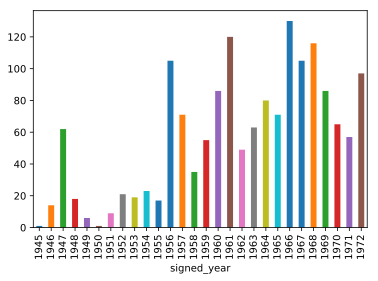

In [94]:
df.loc[df.lemma.isin(['culture', 'cultural'])].groupby(['signed_year']).size().plot(kind='bar')

In [100]:
df.head()

,is_alpha,is_stop,lemma,pos,text,treaty_id,english,filename,french,headnote,...,party2,signed,signed_period,signed_period_alt,signed_year,source,title,topic,topic1,topic2
0,True,False,additional,PROPN,additional,100701,en,100701_en_corr.txt,fr,SCIENTIFIC LITERARY AND EDUCATIONAL RELATIONS,...,FRANCE,1945-12-08,1945 to 1955,1945 to 1955,1945,UNTS,PROTOC,7CULT,7CULT,NaN
1,True,False,protocol,PROPN,protocol,100701,en,100701_en_corr.txt,fr,SCIENTIFIC LITERARY AND EDUCATIONAL RELATIONS,...,FRANCE,1945-12-08,1945 to 1955,1945 to 1955,1945,UNTS,PROTOC,7CULT,7CULT,NaN
2,False,False,declaration,NOUN,declaration concerning scientific,100701,en,100701_en_corr.txt,fr,SCIENTIFIC LITERARY AND EDUCATIONAL RELATIONS,...,FRANCE,1945-12-08,1945 to 1955,1945 to 1955,1945,UNTS,PROTOC,7CULT,7CULT,NaN
3,True,False,literary,PROPN,literary,100701,en,100701_en_corr.txt,fr,SCIENTIFIC LITERARY AND EDUCATIONAL RELATIONS,...,FRANCE,1945-12-08,1945 to 1955,1945 to 1955,1945,UNTS,PROTOC,7CULT,7CULT,NaN
4,True,False,educational,PROPN,educational,100701,en,100701_en_corr.txt,fr,SCIENTIFIC LITERARY AND EDUCATIONAL RELATIONS,...,FRANCE,1945-12-08,1945 to 1955,1945 to 1955,1945,UNTS,PROTOC,7CULT,7CULT,NaN


In [ ]:
df_treaty_pos_tokens = df_corpus[~df_corpus.Stop&~df_corpus.POS.isin(['SPACE', 'PUNCT'])].groupby(['treaty_id', 'Lemma', 'POS']).size()
df_treaty_pos_tokens = df_treaty_pos_tokens.reset_index().rename(columns={'Lemma': 'lemma', 'POS': 'pos', 0: 'count'})
df_treaty_pos_tokens = df_treaty_pos_tokens.set_index(['treaty_id'])
df_treaty_pos_tokens = df_treaty_pos_tokens.merge(pd.DataFrame(treaties['signed_year']), how='inner', left_index=True, right_index=True)

In [108]:

#df_treaty_pos_tokens.head()

df_year_pos_tokens = df.groupby(['lemma', 'pos']).size().reset_index().rename(columns={0:'count'})
df_year_pos_tokens[df_year_pos_tokens.pos.isin(['NOUN'])].nlargest(50, 'count')
#df_year_pos_tokens

,lemma,pos,count
1593,country,NOUN,4400
518,article,NOUN,3924
2331,exchange,NOUN,3458
4502,operation,NOUN,1820
1269,co,NOUN,1652
2564,force,NOUN,1625
3267,institution,NOUN,1601
6306,territory,NOUN,1376
5086,purpose,NOUN,1228
2484,field,NOUN,1100


In [ ]:
df_token_pos = df_corpus[~df_corpus.POS.isin(['SPACE', 'PUNCT'])].groupby(['Lemma', 'POS']).size()

## Text Corpus vs WTI Index

In [96]:
corpus_documents = corpus.documents.set_index(['treaty_id', 'language'])
treaty_text_languages = wti_index.get_treaty_text_languages().set_index(['treaty_id', 'language'])

treaties_in_corpus_not_in_wti = corpus_documents.index.difference(treaty_text_languages.index).get_values()
treaties_in_wti_not_in_corpus = treaty_text_languages.index.difference(corpus_documents.index).get_values()

print(  'Found in corpus, but not in WTI: ' +
        ', '.join([ '{}/{}'.format(x,y) for x,y in treaties_in_corpus_not_in_wti ]))

print(  'Found in WTI, but not in corpus: ' +
        ', '.join([ '{}/{}'.format(x,y) for x,y in treaties_in_wti_not_in_corpus ]))

#corpus_documents.loc[corpus_text_not_in_wti]
#treaty_text_languages.loc[wti_not_in_corpus]

#wti_not_in_corpus

# Duplicates:
#corpus_documents.index.get_duplicates()
#treaty_text_languages.corpus_documents.index.get_duplicates()


AttributeError: 'Corpus' object has no attribute 'documents'

### Task: Basic Corpus Statistics
See https://www.nltk.org/book/ch01.html

* Size of treaties over time
* Unique word, unique words per word class
* Lexical diversity
* Frequency distribution
* Average word length, sentence length


```python
 	
>>> len(texts) / count(docs)
0.06230453042623537
>>>

>>> len(set(text3)) / len(text3)
0.06230453042623537
>>>

>>> > def lexical_diversity(text): [1]
...     return len(set(text)) / len(text) [2]
...
>>> def percentage(count, total): [3]
...     return 100 * count / total

# Most common words
fdist1 = FreqDist(text1)
fdist1.most_common(50)

# Word length frequencies
>>> fdist = FreqDist(len(w) for w in text1)  [2]
>>> print(fdist)

```


In [ ]:
# Code 

corpus = None
def display_token_toplist_interact(source_folder):
    global corpus
    progress_widget = None
    
    def display_token_toplist(source_folder, language, statistics='', remove_stopwords=False):
        global corpus

        try:

            progress_widget.value = 1

            corpus = TreatyCorpusSaveLoad(source_folder=source_folder, lang=language[0]).load_mm_corpus()

            progress_widget.value = 2
            service = MmCorpusStatisticsService(corpus, dictionary=corpus.dictionary, language=language)

            print("Corpus consists of {} documents, {} words in total and a vocabulary size of {} tokens."\
                      .format(len(corpus), corpus.dictionary.num_pos, len(corpus.dictionary)))

            progress_widget.value = 3
            if statistics == 'word_freqs':
                display(service.compute_word_frequencies(remove_stopwords))
            elif statistics == 'documents':
                display(service.compute_document_stats())
            elif statistics == 'word_count':
                display(service.compute_word_stats())
            else:
                print('Unknown: ' + statistics)

        except Exception as ex:
            logger.error(ex)

        progress_widget.value = 5
        progress_widget.value = 0
        return corpus
    
    language_widget=widgets.Dropdown(
        options={
            'English': ('en', 'english'),
            'French': ('fr', 'french'),
            'German': ('de', 'german'),
            'Italian': ('it', 'italian')
        },
        value=('en', 'english'),
        description='Language:', **dict(layout=widgets.Layout(width='260px'))
    )
    
    statistics_widget=widgets.Dropdown(
        options={
            'Word freqs': 'word_freqs',
            'Documents': 'documents',
            'Word count': 'word_count'
        },
        value='word_count',
        description='Statistics:', **dict(layout=widgets.Layout(width='260px'))
    )
    
    remove_stopwords_widget=widgets.ToggleButton(
        description='Remove stopwords', value=True,
        tooltip='Do not include stopwords in token toplist'
    )
    
    progress_widget=widgets.IntProgress(min=0, max=5, step=1, value=0) #, layout=widgets.Layout(width='100%')),

    wi = widgets.interactive(
        display_token_toplist,
        source_folder=source_folder,
        language=language_widget,
        statistics=statistics_widget,
        remove_stopwords=remove_stopwords_widget
    )

    boxes = widgets.HBox(
        [
            language_widget, statistics_widget, remove_stopwords_widget, progress_widget
        ]
    )
    display(widgets.VBox([boxes, wi.children[-1]]))
    wi.update()

display_token_toplist_interact('../data')

### <span style='color: red'>WORK IN PROGRESS</span> Task: Treaty Keyword Extraction (using TF-IDF weighing)
- [ML Wiki.org](http://mlwiki.org/index.php/TF-IDF)
- [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
- Spärck Jones, K. (1972). "A Statistical Interpretation of Term Specificity and Its Application in Retrieval".
- Manning, C.D.; Raghavan, P.; Schutze, H. (2008). "Scoring, term weighting, and the vector space model". ([PDF](http://nlp.stanford.edu/IR-book/pdf/06vect.pdf))
- https://markroxor.github.io/blog/tfidf-pivoted_norm/
$\frac{tf-idf}{\sqrt(rowSums( tf-idf^2 ) )}$
- https://nlp.stanford.edu/IR-book/html/htmledition/pivoted-normalized-document-length-1.html

Neural Network Methods in Natural Language Processing, Yoav Goldberg:
![image.png](attachment:image.png)

In [ ]:
# Code
from scipy.sparse import csr_matrix
%timeit

    
def get_top_tfidf_words(data, n_top=5):
    top_list = data.groupby(['treaty_id'])\
        .apply(lambda x: x.nlargest(n_top, 'score'))\
        .reset_index(level=0, drop=True)
    return top_list

def compute_tfidf_scores(corpus, dictionary, smartirs='ntc'):
    #model = gensim.models.logentropy_model.LogEntropyModel(corpus, normalize=True)
    model = gensim.models.tfidfmodel.TfidfModel(corpus, dictionary=dictionary, normalize=True) #, smartirs=smartirs)
    rows, cols, scores = [], [], []
    for r, document in enumerate(corpus): 
        vector = model[document]
        c, v = zip(*vector)
        rows += (len(c) * [ int(r) ])
        cols += c
        scores += v
        
    return csr_matrix((scores, (rows, cols)))
    
if True: #'tfidf_cache' not in globals():
    tfidf_cache = {
    }
    
def display_tfidf_scores(source_folder, language, period, n_top=5, threshold=0.001):
    
    global state, tfw, tfidf_cache
    
    try:
        treaties = state.treaties

        tfw.progress.value = 0
        tfw.progress.value += 1
        if language[0] not in tfidf_cache.keys():
            corpus = TreatyCorpusSaveLoad(source_folder=source_folder, lang=language[0])\
                .load_mm_corpus(normalize_by_D=True)
            document_names = corpus.document_names
            dictionary = corpus.dictionary
            _ = dictionary[0]

            tfw.progress.value += 1
            A = compute_tfidf_scores(corpus, dictionary)

            tfw.progress.value += 1
            scores = pd.DataFrame(
                [ (i, j, dictionary.id2token[j], A[i, j]) for i, j in zip(*A.nonzero())],
                columns=['document_id', 'token_id', 'token', 'score']
            )
            tfw.progress.value += 1
            scores = scores.merge(document_names, how='inner', left_on='document_id', right_index=True)\
                .drop(['document_id', 'token_id', 'document_name'], axis=1)

            scores = scores[['treaty_id', 'token', 'score']]\
                .sort_values(['treaty_id', 'score'], ascending=[True, False])

            tfidf_cache[language[0]] = scores

        scores = tfidf_cache[language[0]]
        if threshold > 0:
            scores = scores.loc[scores.score >= threshold]

        tfw.progress.value += 1

        #scores = get_top_tfidf_words(scores, n_top=5)
        #scores = scores.groupby(['treaty_id']).sum() 

        scores = scores.groupby(['treaty_id'])\
            .apply(lambda x: x.nlargest(n_top, 'score'))\
            .reset_index(level=0, drop=True)\
            .set_index('treaty_id')

        if period is not None:
            periods = state.treaties[period]
            scores = scores.merge(periods.to_frame(), left_index=True, right_index=True, how='inner')\
                .groupby([period, 'token']).score.agg([np.mean])\
                .reset_index().rename(columns={0:'score'}) #.sort_values('token')

        #['token'].apply(' '.join)

        display(scores)
    except Exception as ex:
        logger.error(ex)
        
    tfw.progress.value = 0

#if 'tfidf_scores' not in globals():
#    tfidf_scores = compute_document_tfidf(corpus, corpus.dictionary, state.treaties)
#    tfidf_scores = tfidf_scores.sort_values(['treaty_id', 'score'], ascending=[True, False])

tfw = BaseWidgetUtility(
    language=widgets.Dropdown(
        options={
            'English': ('en', 'english'),
            'French': ('fr', 'french'),
            'German': ('de', 'german'),
            'Italian': ('it', 'italian')
        },
        value=('en', 'english'),
        description='Language:', **drop_style
    ),
    remove_stopwords=widgets.ToggleButton(
        description='Remove stopwords', value=True,
        tooltip='Do not include stopwords in token toplist', **toggle_style
    ),    
    n_top=widgets.IntSlider(
        value=5, min=1, max=25, step=1,
        description='Top #:',
        continuous_update=False
    ),
    threshold=widgets.FloatSlider(
        value=0.001, min=0.0, max=0.5, step=0.01,
        description='Threshold:',
        tooltip='Word having a TF-IDF score below this value is filtered out',
        continuous_update=False,
        readout_format='.3f',
    ), 
    period=widgets.Dropdown(
        options={
            '': None,
            'Year': 'signed_year',
            'Default division': 'signed_period',
            'Alt. division': 'signed_period_alt'
        },
        value='signed_period',
        description='Period:', **drop_style
    ),
    output=widgets.Dropdown(
        options={
            '': None,
            'Year': 'signed_year',
            'Default division': 'signed_period',
            'Alt. division': 'signed_period_alt'
        },
        value='signed_period',
        description='Output:', **drop_style
    ),
    progress=widgets.IntProgress(min=0, max=5, step=1, value=0) #, layout=widgets.Layout(width='100%')),
)

itfw = widgets.interactive(
    display_tfidf_scores,
    source_folder='./data',
    language=tfw.language,
    n_top=tfw.n_top,
    threshold=tfw.threshold,
    period=tfw.period
)

boxes = widgets.HBox(
    [
        widgets.VBox([tfw.language, tfw.period]),
        widgets.VBox([tfw.n_top, tfw.threshold]),
        widgets.VBox([tfw.progress, tfw.output])
    ]
)

display(widgets.VBox([boxes, itfw.children[-1]]))
itfw.update()
